# Workshop 5, Stats for AI - Bloque 2

Imanol Muñiz Ramirez A01701713

In [2]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas_datareader as pdr
import matplotlib.ticker as mticker

## CHALLENGE 1
Download the Real Gross Domestic Product for Mexico from the FRED online site (US Federal Reserve Bank). Use the ticker NGDPRNSAXDCMXQ. You have to:
* Calibrate an ARIMA-SARIMA to forecast the Mexico GDP for the the rest of 2025 and all quarters of 2026.

* You have to explain your calibration steps, and

* Interpret the final model.

Primero importamos los datos desde con el api de la plataforma de FRED.

In [3]:
series_id = "NGDPRNSAXDCMXQ"
mxgdpdf = pdr.get_data_fred(series_id,start='1993-01-01')
mxgdpdf.columns=['MXGDP']
print(mxgdpdf.head())

                MXGDP
DATE                 
1993-01-01  3439763.5
1993-04-01  3472286.3
1993-07-01  3465719.7
1993-10-01  3519338.2
1994-01-01  3525020.1


Los graficamos. Podemos observar como el GDP de México tiene un tendencia positiva a través del tiempo por lo que no son datos estacionarios. Debemos transformar la información para que los datos sean estacionarios para poder usar un modelo arima-sarima

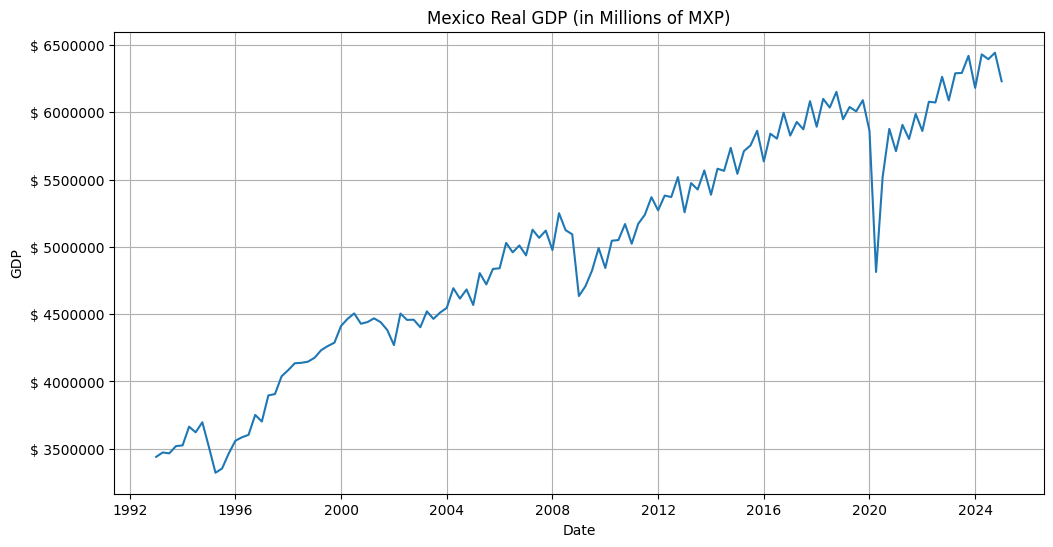

In [4]:

plt.figure(figsize=(12, 6))
plt.plot(mxgdpdf.index, mxgdpdf['MXGDP'])
plt.title('Mexico Real GDP (in Millions of MXP)')
plt.xlabel('Date')
plt.ylabel('GDP')
formatter = mticker.FormatStrFormatter('$ %1.0f')
plt.gca().yaxis.set_major_formatter(formatter)
plt.grid(True)
plt.show()

Transformamos la columna MXGDP con el logaritmo para ver el porcentaje de crecimiento a través del tiempo. Es importante notar que los datos vienen por periodos trimestrales, por lo que para ver el crecimiento anual es necesario compara el registro actual con el actual + 4. Podemos observar del gráfico que la tendencia de crecimiento aparentemente se desvanecio. Esto nos indica que el porcentaje de crecimiento del GDP de México ha variado cada año más o menos lo mismo.

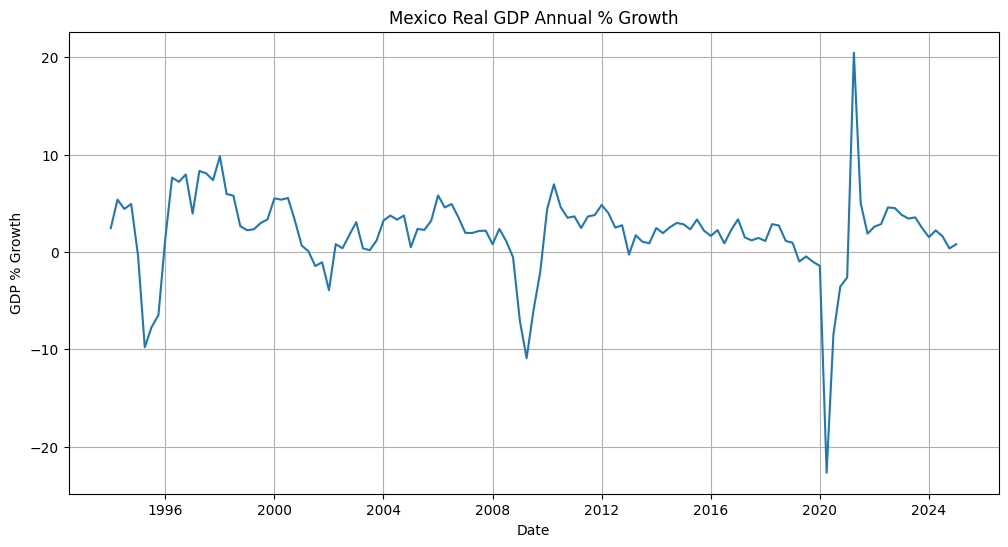

In [12]:
mxgdpdf['logMXGDP'] = np.log(mxgdpdf['MXGDP'])
mxgdpdf['annualgrowth'] = mxgdpdf['logMXGDP'] - mxgdpdf['logMXGDP'].shift(4)
plt.figure(figsize=(12, 6))
plt.plot(mxgdpdf.index, 100*mxgdpdf['annualgrowth'])
plt.title('Mexico Real GDP Annual % Growth')
plt.xlabel('Date')
plt.ylabel('GDP % Growth')
plt.grid(True)
plt.show()

Para probar que efectivamente la estacionariedad de los datos vamos a emplear la prueba de Dicky Fuller. Obtenemos que el p-value es menor a 0.05 por lo que efectivamente el porcentaje de crecimiento anual del GDP es estacionario. Concluimos que nuestros paramétros d=0 y D=1 pueden funcionar para nuestro modelo.

In [13]:
dftest = adfuller(mxgdpdf['annualgrowth'].dropna())
print('ADF Statistic: %f' % dftest[0])
print('p-value: %f' % dftest[1])
print('Critical Values:')
for key, value in dftest[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.527930
p-value: 0.007298
Critical Values:
	1%: -3.488
	5%: -2.887
	10%: -2.580


Hacemos lo análogo para verificar si el crecimiento del GDP trimestral es estacionario

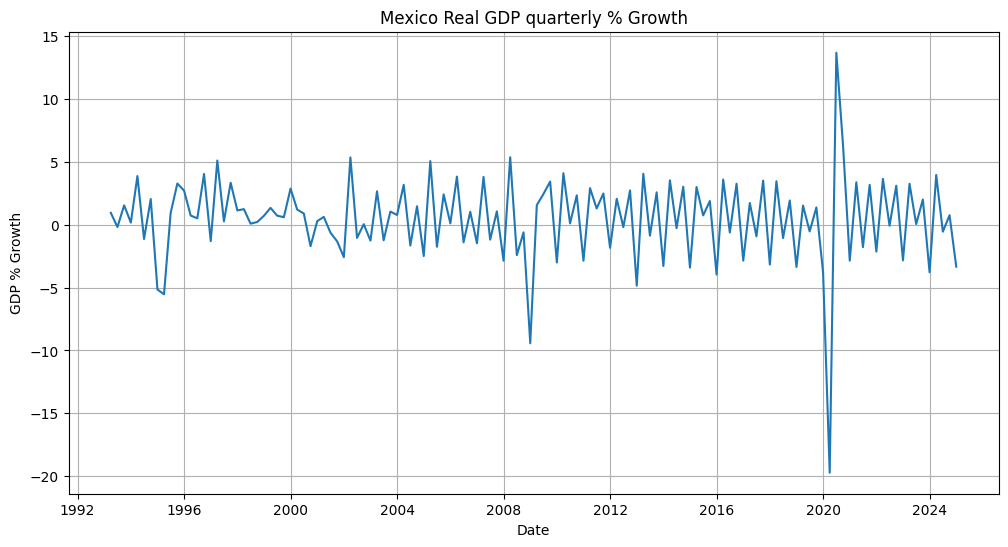

In [14]:
mxgdpdf['quarterlygrowth'] = mxgdpdf['logMXGDP'] - mxgdpdf['logMXGDP'].shift(1)
plt.figure(figsize=(12, 6))
plt.plot(mxgdpdf.index, 100*mxgdpdf['quarterlygrowth'])
plt.title('Mexico Real GDP quarterly % Growth')
plt.xlabel('Date')
plt.ylabel('GDP % Growth')
plt.grid(True)
plt.show()

Al hacer la prueba de Dicky Fuller para periodos trimestrales, podemos ver que el crecimiento porcentual del GDP es también estacionario. Por lo que los parámetros d=1 y D=0 también podrían funcionar en nuestro modelo e incluso mejor que la alternativa anterior pues tiene un p-value menor.

In [15]:
dftest = adfuller(mxgdpdf['quarterlygrowth'].dropna())
print('ADF Statistic: %f' % dftest[0])
print('p-value: %f' % dftest[1])
print('Critical Values:')
for key, value in dftest[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.394695
p-value: 0.000000
Critical Values:
	1%: -3.484
	5%: -2.885
	10%: -2.579


Hacemos una gráfica de autocorrelación para verificar que tanto repercuten los lags anteriores al acual. Podemos ver que solo los primeros dos son significativos por lo que para nuestro modelo arima-sarima podríamos incluir un parámetro P de 1 o 2.

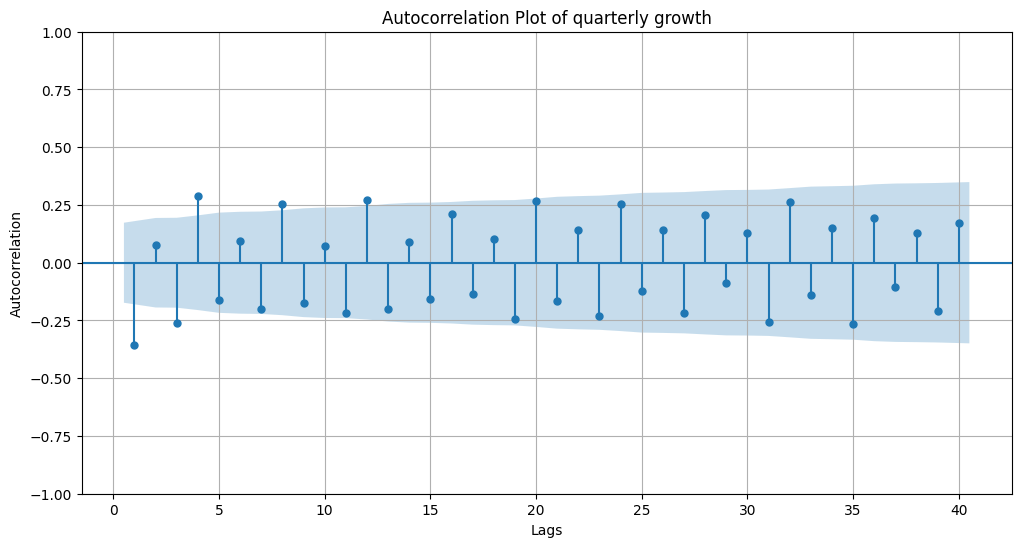

In [18]:
quarterly_growth = mxgdpdf.dropna(subset=['quarterlygrowth'])
# Autocorrelation plot
plt.figure(figsize=(12, 6))
plot_acf(quarterly_growth['quarterlygrowth'], lags=40, zero=False, ax=plt.gca())
plt.title('Autocorrelation Plot of quarterly growth')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

Sin embargo, al obtener la correlación parcial podemos apreciar que el lag 2 deja de ser significativo. Lo que indica que su significancia en el gráfico de autocorrelación estaba más involucrada por la correlación con el lag 1. Por lo que debemos porbar primero únicamente con un parámetro P de 1.

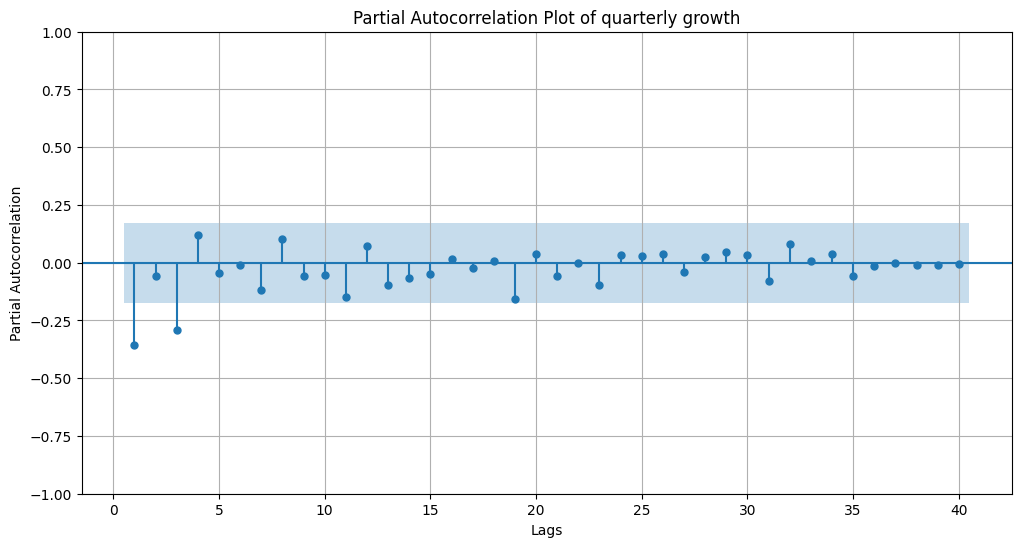

In [19]:
# Partial autocorrelation plot
plt.figure(figsize=(12, 6))
plot_pacf(quarterly_growth['quarterlygrowth'], zero=False, lags=40, ax=plt.gca())
plt.title('Partial Autocorrelation Plot of quarterly growth')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.grid(True)
plt.show()

Finalmente con el análisis anterior podemos calibrar nuestro modelo arima-sarima con los parámetros (p=1,d=1,q=0), (P=1,D=0,Q=0,#periods=4).

In [20]:
mxgdp_log = mxgdpdf['logMXGDP'].dropna() #Tomamos el logaritmo del PIB

# Fit SARIMA model ARIMA(p=1,d=0,q=0) SARIMA(P=0,D=1,Q=0,#periods=4)
model = SARIMAX(mxgdp_log, order=(1, 1, 0), #Tomamos p=1,d=0,q=0
                seasonal_order=(1, 0, 0, 4), #Tomamos P=0,D=1,Q=0,periods=4
                trend='c')

result = model.fit()
print(result.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                          logMXGDP   No. Observations:                  129
Model:             SARIMAX(1, 1, 0)x(1, 0, 0, 4)   Log Likelihood                 262.654
Date:                           Tue, 11 Nov 2025   AIC                           -517.308
Time:                                   19:10:00   BIC                           -505.900
Sample:                               01-01-1993   HQIC                          -512.673
                                    - 01-01-2025                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0048      0.003      1.413      0.158      -0.002       0.012
ar.L1         -0.3046      0.047     -6.428

Como era de esperarse el porcentaje de crecimiento por periodo y anual es significativo. Finalmente analicemos los residuos por periodo y anuales para calibrar q y Q. De las gráficas de abajo podemos conlcuir que los residuos no son significativos en el modelo por lo que funciona bien con q y Q igual a cero.

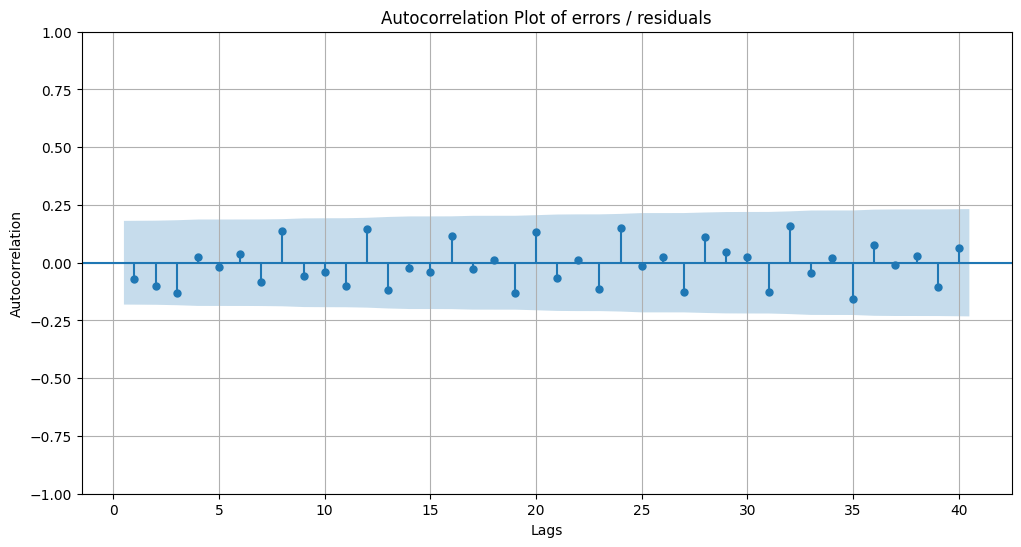

In [24]:
plt.figure(figsize=(12, 6))
plot_acf(result.resid.iloc[12:], lags=40, zero=False, ax=plt.gca())
plt.title('Autocorrelation Plot of errors / residuals')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

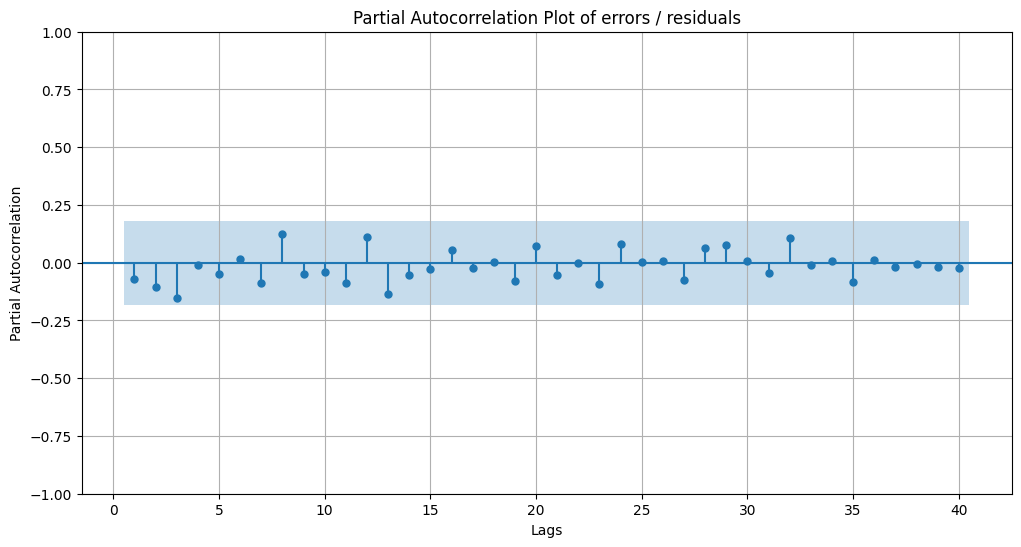

In [25]:
plt.figure(figsize=(12, 6))
plot_pacf(result.resid.iloc[12:], lags=40, zero=False, ax=plt.gca())
plt.title('Partial Autocorrelation Plot of errors / residuals')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.grid(True)
plt.show()

Podemos concluir que nuestro modelo tiene los parámetros

* p=1,d=1,q=0
* P=1,D=0,Q=0

Y se obtienen los coeficientes

* phi0 = 0.0048
* phi1 = -0.3046
* phi2 = 0.2124

Para que nuestra ecuación de predicción sea

$log(Y_t) = 0.0048 - 0.3046 * log(Y_{t-1}) + 0.2124 * log(Y_{t-4})$

In [28]:
print(result.summary())

                                     SARIMAX Results                                     
Dep. Variable:                          logMXGDP   No. Observations:                  129
Model:             SARIMAX(1, 1, 0)x(1, 0, 0, 4)   Log Likelihood                 262.654
Date:                           Tue, 11 Nov 2025   AIC                           -517.308
Time:                                   19:33:37   BIC                           -505.900
Sample:                               01-01-1993   HQIC                          -512.673
                                    - 01-01-2025                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0048      0.003      1.413      0.158      -0.002       0.012
ar.L1         -0.3046      0.047     -6.428

Cómo se quiere predecir para los valores restantes del 2025 y todo 2026, se ocupa predecir los próximos 7 periodos.

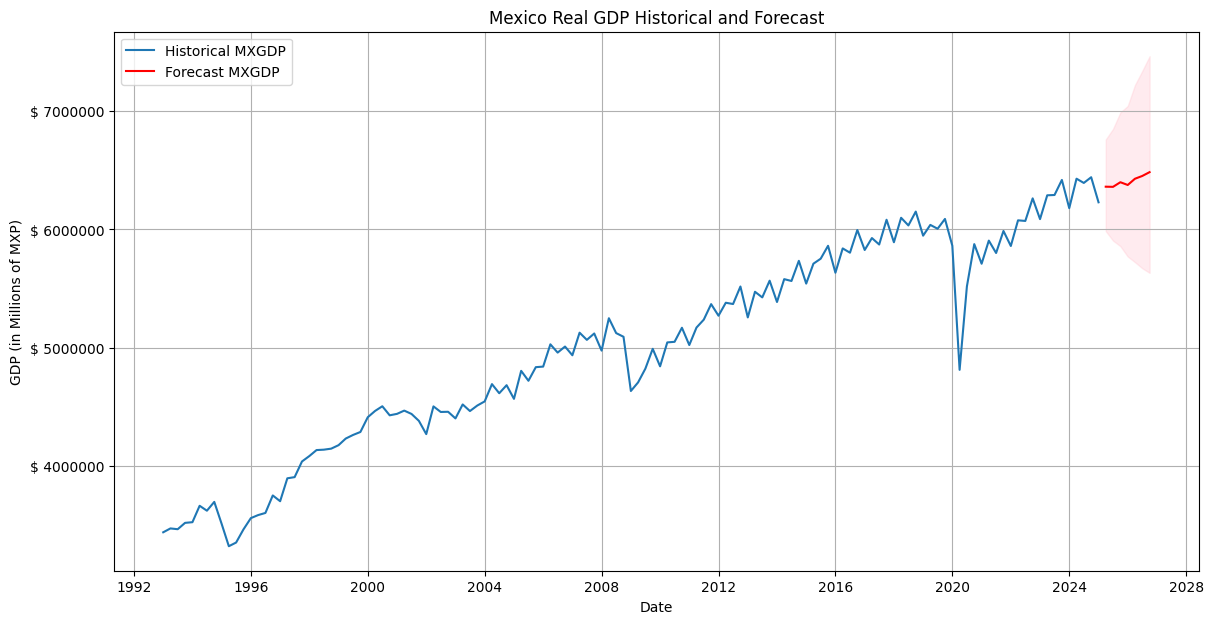

In [30]:
forecast_steps = 7
forecast_result = result.get_forecast(steps=forecast_steps)
forecast_log = forecast_result.predicted_mean
forecast_ci = forecast_result.conf_int(alpha=0.05)
forecast_values = np.exp(forecast_log)

plt.figure(figsize=(14, 7))
plt.plot(mxgdpdf.index, mxgdpdf['MXGDP'], label='Historical MXGDP')
plt.plot(forecast_values.index, forecast_values, label='Forecast MXGDP', color='red')
plt.fill_between(forecast_values.index, np.exp(forecast_ci.iloc[:, 0]), np.exp(forecast_ci.iloc[:, 1]), color='pink', alpha=0.3)
plt.title('Mexico Real GDP Historical and Forecast')
plt.xlabel('Date')
plt.ylabel('GDP (in Millions of MXP)')
formatter = mticker.FormatStrFormatter('$ %1.0f')
plt.gca().yaxis.set_major_formatter(formatter)
plt.grid(True)
plt.legend()
plt.show()

## CHALLENGE 2
Do the same as above, but now for the US Real GDP: Download the Real Gross Domestic Product for the US from the FRED online site (US Federal Reserve Bank). Use the ticker NGDPRNSAXDCMXQ. You have to:

* Calibrate an ARIMA-SARIMA to forecast the US GDP for the the rest of 2025 and all quarters of 2026.

* Using your previous Mexico SARIMA model, use the US GDP annual % growth as an explanatory variable (exogenous variable).

* Interpret the final model.

Hacemos un proceso totalmente análogo al que hicimos con México

In [31]:
series_id = "GDPC1"
usgdpdf = pdr.get_data_fred(series_id,start='1993-01-01')
usgdpdf.columns=['USGDP']
print(usgdpdf.head())

                USGDP
DATE                 
1993-01-01  10576.275
1993-04-01  10637.847
1993-07-01  10688.606
1993-10-01  10833.987
1994-01-01  10939.116


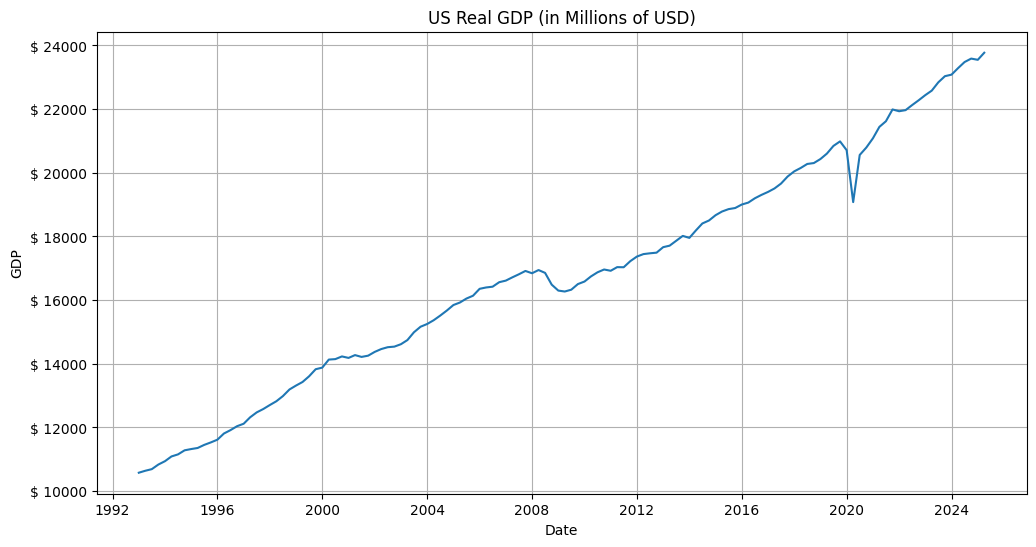

In [32]:
plt.figure(figsize=(12, 6))
plt.plot(usgdpdf.index, usgdpdf['USGDP'])
plt.title('US Real GDP (in Millions of USD)')
plt.xlabel('Date')
plt.ylabel('GDP')
# Format the y-axis to show in currency format
formatter = mticker.FormatStrFormatter('$ %1.0f')
plt.gca().yaxis.set_major_formatter(formatter)

plt.grid(True)
plt.show()

Al igual que en el challege 1 se saca la diferencia entre años, indicando que se trata de crecimiento anual

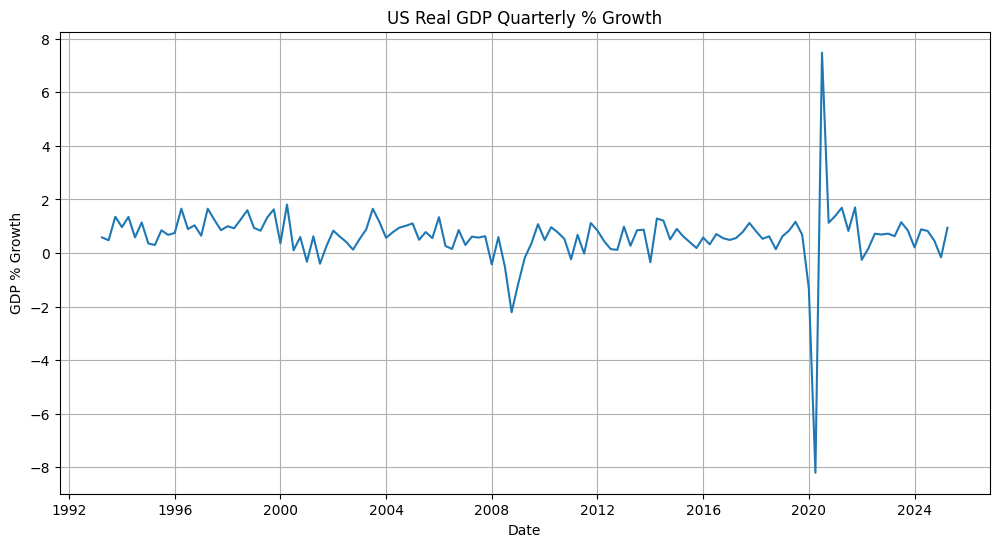

In [39]:
usgdpdf['logUSGDP'] = np.log(usgdpdf['USGDP'])
usgdpdf['quarterlygrowth'] = usgdpdf['logUSGDP'] - usgdpdf['logUSGDP'].shift(1)
plt.figure(figsize=(12, 6))
plt.plot(usgdpdf.index, 100*usgdpdf['quarterlygrowth'])
plt.title('US Real GDP Quarterly % Growth')
plt.xlabel('Date')
plt.ylabel('GDP % Growth')
plt.grid(True)
plt.show()

Con el p-value menor a 0.05 de la prueba de Dicky Fuller podemos concluir que el crecimiento porcentual por cuatrimestre del GDP de estados unidos es estacionario. Esto nos indica que el parámetro d = 1 y D=0 de nuestro modelo arima-sarima es el correcto.

In [40]:
dftest = adfuller(usgdpdf['quarterlygrowth'].dropna())
print('ADF Statistic: %f' % dftest[0])
print('p-value: %f' % dftest[1])
print('Critical Values:')
for key, value in dftest[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -13.103152
p-value: 0.000000
Critical Values:
	1%: -3.483
	5%: -2.884
	10%: -2.579


Hagamos nuestros gráficos de autocorrelación para definir los parámetros p y P. Podemos observar que la autocorrelación del crecimiento trimestral del GDP de Estados Unidos no es significativa entre periodos subsecuentes ni parciales por lo que usarémos los paramétros p y P igual a cero para nuestro modelo arima-sarima

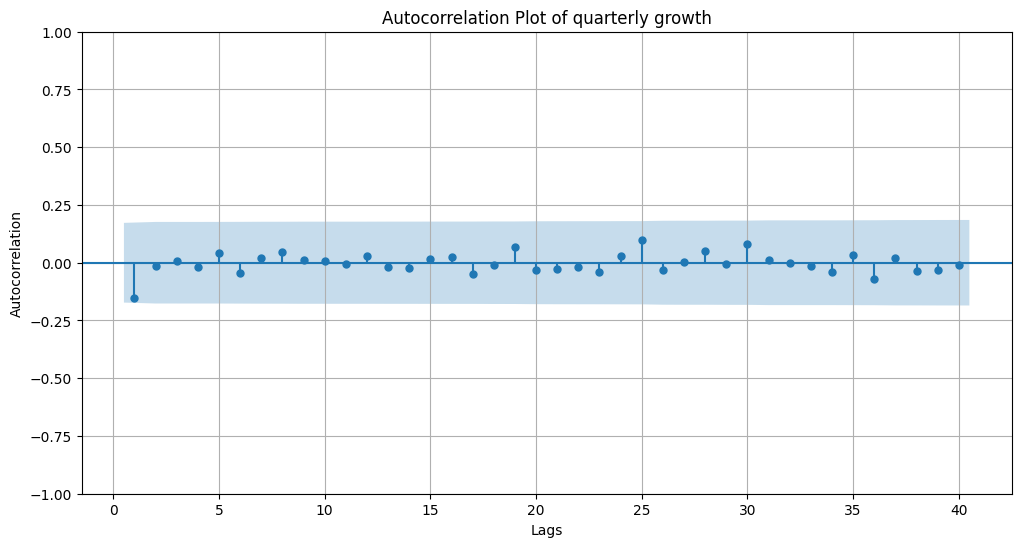

In [41]:
quarterly_growth = usgdpdf.dropna(subset=['quarterlygrowth'])
# Autocorrelation plot
plt.figure(figsize=(12, 6))
plot_acf(quarterly_growth['quarterlygrowth'], lags=40, zero=False, ax=plt.gca())
plt.title('Autocorrelation Plot of quarterly growth')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

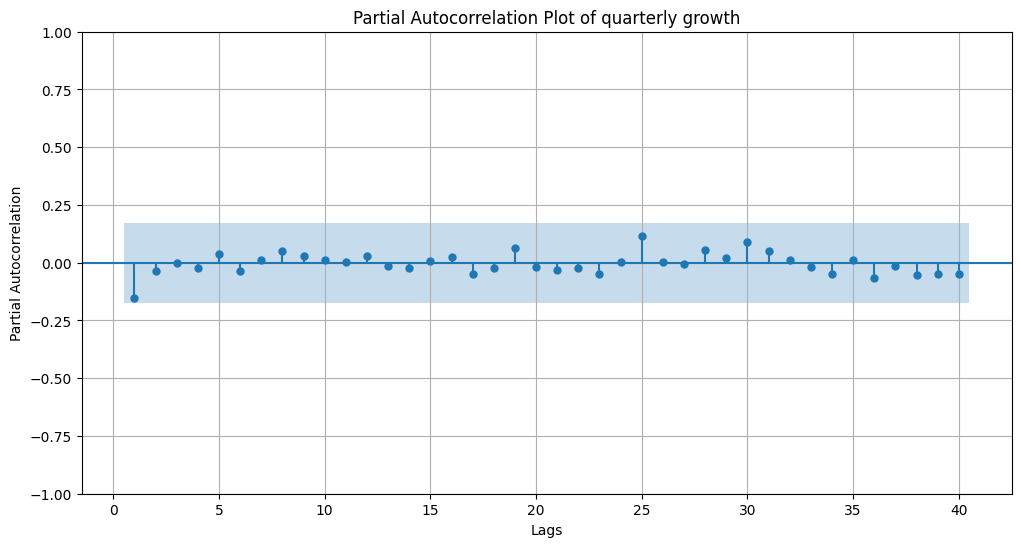

In [42]:
# Partial autocorrelation plot
plt.figure(figsize=(12, 6))
plot_pacf(quarterly_growth['quarterlygrowth'], zero=False, lags=40, ax=plt.gca())
plt.title('Partial Autocorrelation Plot of quarterly growth')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.grid(True)
plt.show()

Probamos nuestro modelo con los parámetros que encontramos.

In [51]:
usgdpdf_log = usgdpdf['logUSGDP'].dropna()
model = SARIMAX(usgdpdf_log, order=(0, 1, 0),
                seasonal_order=(0, 0, 0, 4),
                trend='c')
result = model.fit()
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:               logUSGDP   No. Observations:                  130
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 393.553
Date:                Tue, 11 Nov 2025   AIC                           -783.106
Time:                        20:23:11   BIC                           -777.386
Sample:                    01-01-1993   HQIC                          -780.782
                         - 04-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0063      0.001      5.857      0.000       0.004       0.008
sigma2         0.0001   4.04e-06     32.425      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   3.12   Jarque-

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


Aunque del análisis hayamos concluido que no hay correlación de los periodos o años anteriores con el actual, aún podemos encontrar si el cambio del GDP se debe a otros factores que no tenemos contemplados. Verifiquemos si los residuos explican mejor el crecimiento del GDP de Estados Unidos. De las gráficas de abajo podemos pareciar que los residuos tampoco son significativos. Podemos concluir que el cambio de GDP no depende de resultados anteriores por lo que un modelo de series de tiempo puede no ser el más adecuado

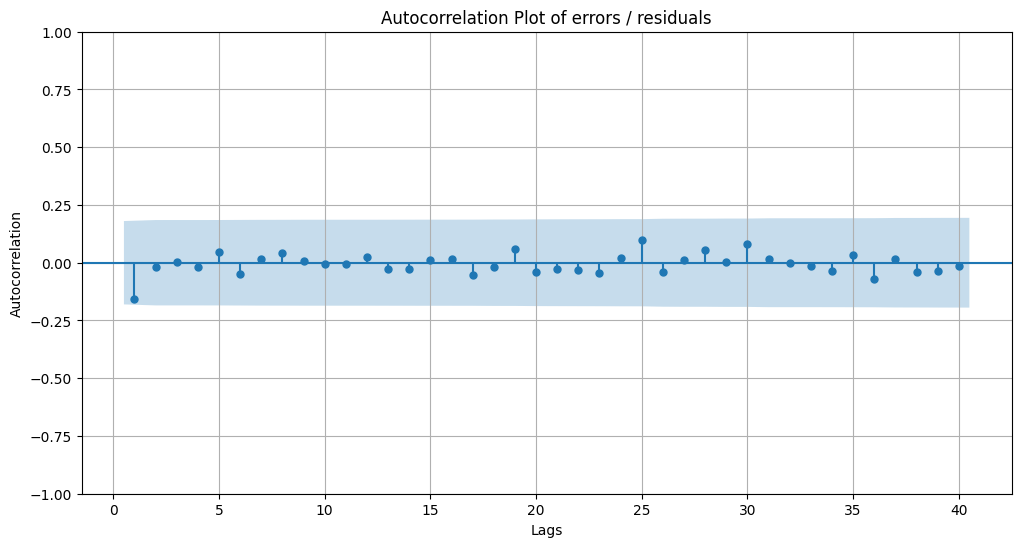

In [53]:
plt.figure(figsize=(12, 6))
plot_acf(result.resid.iloc[12:], lags=40, zero=False, ax=plt.gca())
plt.title('Autocorrelation Plot of errors / residuals')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

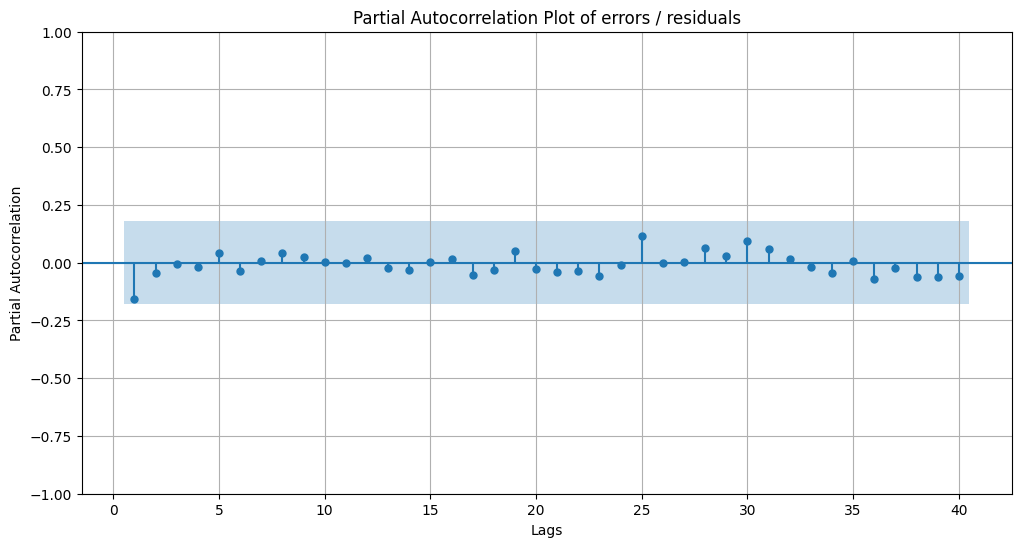

In [54]:
plt.figure(figsize=(12, 6))
plot_pacf(result.resid.iloc[12:], lags=40, zero=False, ax=plt.gca())
plt.title('Partial Autocorrelation Plot of errors / residuals')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.grid(True)
plt.show()

Este modelo tiene los parámetros

* p=0,d=1,q=0
* P=0,D=0,Q=0

Y se obtienen los coeficientes

* phi0 = 0.0063

Para que nuestra ecuación de predicción sea

$log(Y_t) = 0.0063$

In [55]:
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:               logUSGDP   No. Observations:                  130
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 393.553
Date:                Tue, 11 Nov 2025   AIC                           -783.106
Time:                        20:30:05   BIC                           -777.386
Sample:                    01-01-1993   HQIC                          -780.782
                         - 04-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0063      0.001      5.857      0.000       0.004       0.008
sigma2         0.0001   4.04e-06     32.425      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   3.12   Jarque-

Predicciones para 2025 y 2026:

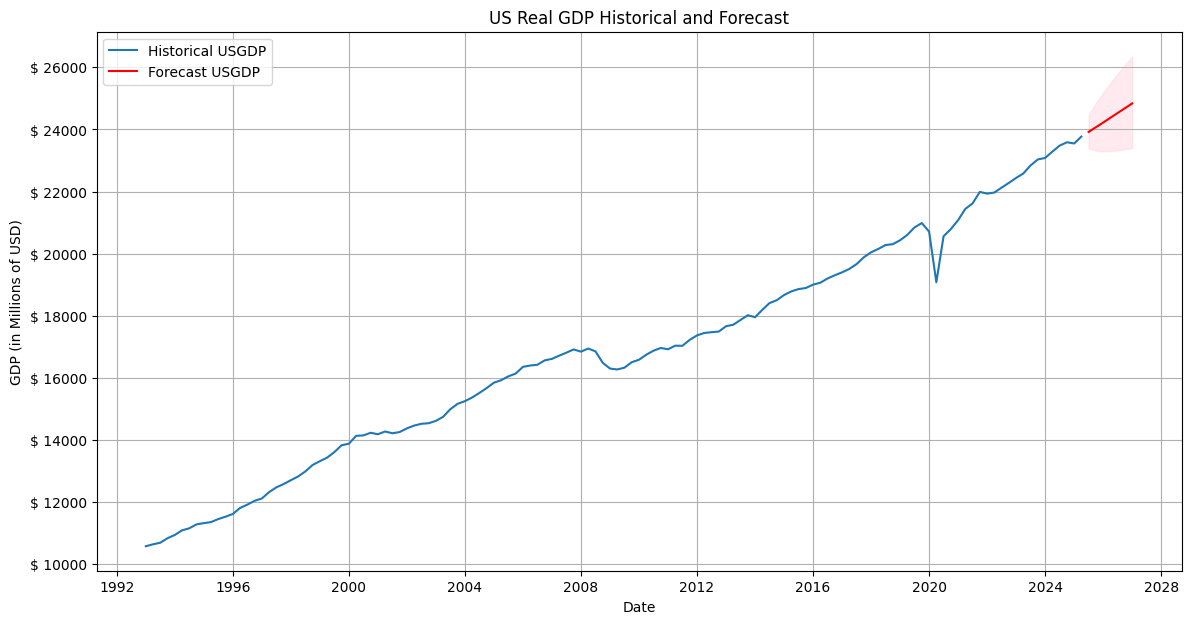

In [56]:
forecast_steps = 7
forecast_result = result.get_forecast(steps=forecast_steps)
forecast_log = forecast_result.predicted_mean
forecast_ci = forecast_result.conf_int(alpha=0.05)
forecast_values = np.exp(forecast_log)

plt.figure(figsize=(14, 7))
plt.plot(usgdpdf.index, usgdpdf['USGDP'], label='Historical USGDP')
plt.plot(forecast_values.index, forecast_values, label='Forecast USGDP', color='red')
plt.fill_between(forecast_values.index, np.exp(forecast_ci.iloc[:, 0]), np.exp(forecast_ci.iloc[:, 1]), color='pink', alpha=0.3) # Plot confidence interval
plt.title('US Real GDP Historical and Forecast')
plt.xlabel('Date')
plt.ylabel('GDP (in Millions of USD)')
formatter = mticker.FormatStrFormatter('$ %1.0f')
plt.gca().yaxis.set_major_formatter(formatter)
plt.grid(True)
plt.legend()
plt.show()

### Estados Unidos GDP como variable explicativa externa

Para esto volvemos a generar el modelo al que llegamos para el GDP de México y añadimos a la configuración exog=usgdp_log en el modelo SARIMAX. Del resumen podemos apreciar que el GDP de Estados Unidos es una variable expicativa del GDP de México.

In [57]:
usgdp_log = usgdpdf['logUSGDP'].dropna() #Tomamos el logaritmo del PIB
usgdp_log = usgdp_log.iloc[:-1]
mxgdp_log = mxgdpdf['logMXGDP'].dropna() #Tomamos el logaritmo del PIB
model = SARIMAX(mxgdp_log, order=(1, 1, 0),
            seasonal_order=(1, 0, 0, 4),
            exog=usgdp_log,
            trend='c')
result = model.fit()
print(result.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                          logMXGDP   No. Observations:                  129
Model:             SARIMAX(1, 1, 0)x(1, 0, 0, 4)   Log Likelihood                 320.910
Date:                           Tue, 11 Nov 2025   AIC                           -631.820
Time:                                   20:36:39   BIC                           -617.560
Sample:                               01-01-1993   HQIC                          -626.027
                                    - 01-01-2025                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0065      0.002     -2.731      0.006      -0.011      -0.002
logUSGDP       1.9895      0.110     18.035

Observemos si los residuos de este nuevo modelo son significativos. De las gráficas de abajo vemos que aunque hay ciertos lags que son significativos por un poco, no coinciden con los trimestres anteriores ni años previos por lo que voy a dejar el modelo tal como está.

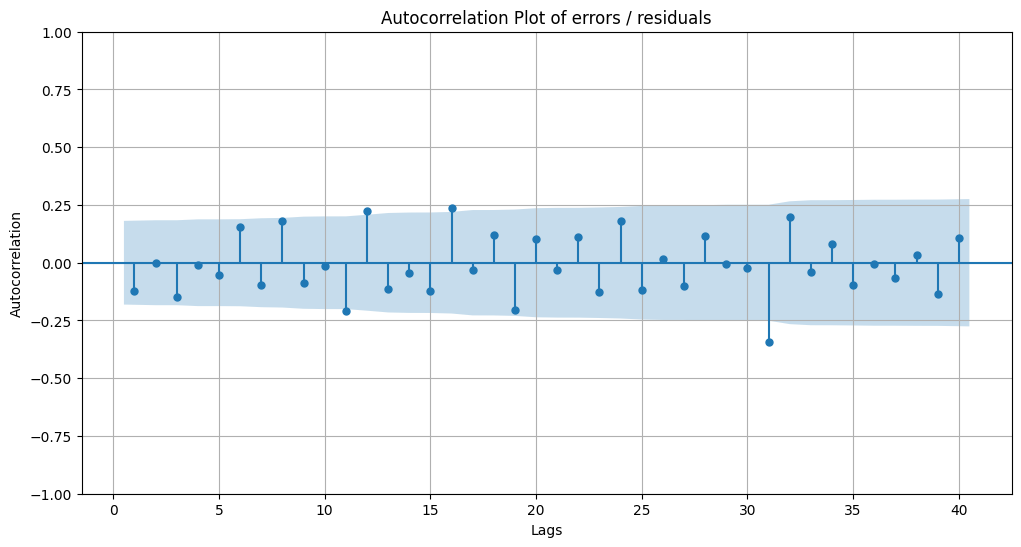

In [58]:
plt.figure(figsize=(12, 6))
plot_acf(result.resid.iloc[12:], lags=40, zero=False, ax=plt.gca())
plt.title('Autocorrelation Plot of errors / residuals')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

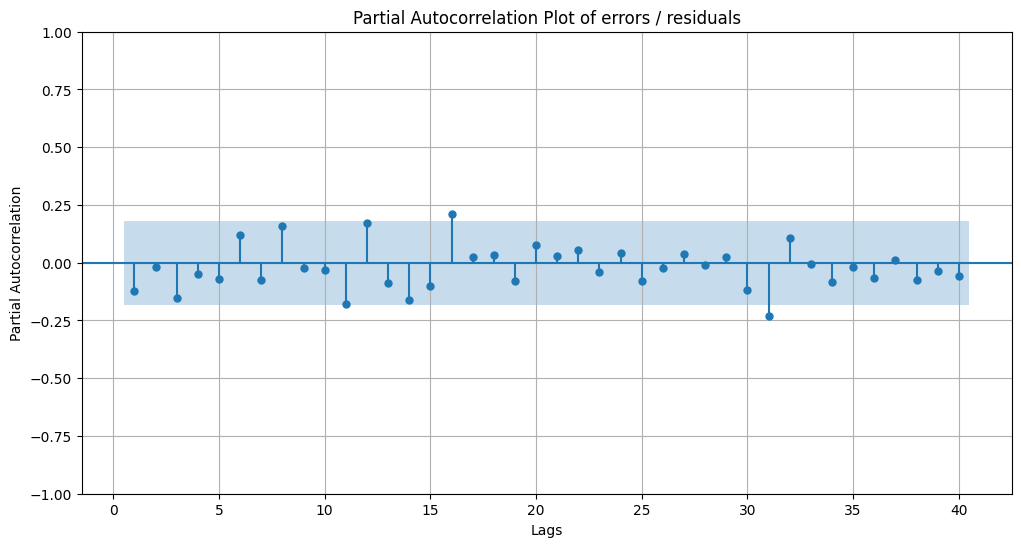

In [59]:
plt.figure(figsize=(12, 6))
plot_pacf(result.resid.iloc[12:], lags=40, zero=False, ax=plt.gca())
plt.title('Partial Autocorrelation Plot of errors / residuals')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.grid(True)
plt.show()

Podemos concluir que nuestro modelo que explica el cambio del GDP de México considerando el GDP de Estados Unidos tiene los paramétros.

* p=1,d=1,q=0
* P=1,D=0,Q=0
* exog=usgdp_log

Y se obtienen los coeficientes

* phi0 = -0.0065
* phi1 = -0.3834
* phi2 = 0.4040
* logUSGDP = 1.9895

Para que nuestra ecuación de predicción sea

$log(Y_t) = - 0.0065 - 0.3834 * log(Y_{t-1}) + 0.4040 * log(Y_{t-4}) + 1.9895 * usgdplog(Y_t)$

In [60]:
print(result.summary())

                                     SARIMAX Results                                     
Dep. Variable:                          logMXGDP   No. Observations:                  129
Model:             SARIMAX(1, 1, 0)x(1, 0, 0, 4)   Log Likelihood                 320.910
Date:                           Tue, 11 Nov 2025   AIC                           -631.820
Time:                                   20:49:06   BIC                           -617.560
Sample:                               01-01-1993   HQIC                          -626.027
                                    - 01-01-2025                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0065      0.002     -2.731      0.006      -0.011      -0.002
logUSGDP       1.9895      0.110     18.035

Visualizamos las predicciones del modelo final para los años 2025 y 2026

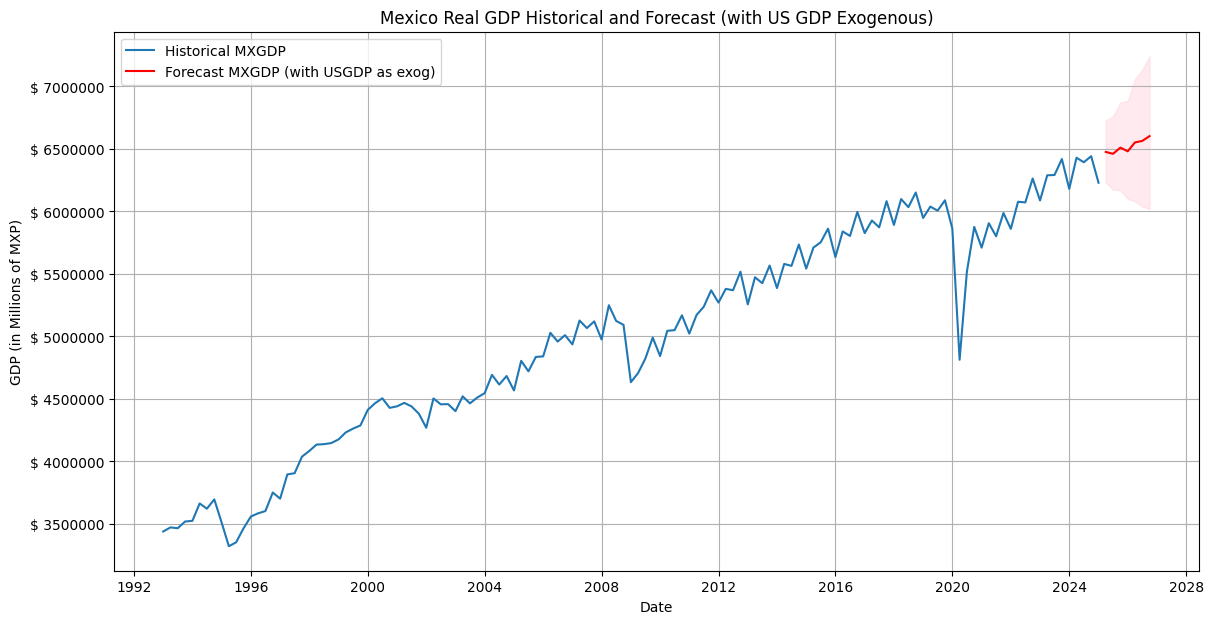

In [62]:
forecast_steps = 7
# Pass the forecasted US GDP (forecast_log) as the exogenous variable for forecasting Mexico's GDP
forecast_result = result.get_forecast(steps=forecast_steps, exog=forecast_log)
forecast_log_mx = forecast_result.predicted_mean
forecast_ci_mx = forecast_result.conf_int(alpha=0.05)
forecast_values_mx = np.exp(forecast_log_mx)

plt.figure(figsize=(14, 7))
plt.plot(mxgdpdf.index, mxgdpdf['MXGDP'], label='Historical MXGDP')
plt.plot(forecast_values_mx.index, forecast_values_mx, label='Forecast MXGDP (with USGDP as exog)', color='red')
plt.fill_between(forecast_values_mx.index, np.exp(forecast_ci_mx.iloc[:, 0]), np.exp(forecast_ci_mx.iloc[:, 1]), color='pink', alpha=0.3) # Plot confidence interval
plt.title('Mexico Real GDP Historical and Forecast (with US GDP Exogenous)')
plt.xlabel('Date')
plt.ylabel('GDP (in Millions of MXP)')
formatter = mticker.FormatStrFormatter('$ %1.0f')
plt.gca().yaxis.set_major_formatter(formatter)
plt.grid(True)
plt.legend()
plt.show()